# 比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
* SGD
* RMSprop
* AdaGrad
* Adam

In [0]:
# 從網路即時下載CIFAR10⼩圖像，數據集涵蓋50,000張32x32彩⾊色訓練圖像及10,000張測試圖像，並且標註超過10個類別
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 查詢檔案維度資訊
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


In [0]:
# 資料前處理
def preproc_x(x):
    x = x.reshape((len(x), -1)) / 255.
    return x

def preproc_y(y, num_classes=10):
    from keras.utils import to_categorical

    y = to_categorical(y, num_classes)
    return y    

In [0]:
# 將資料從圖形 (RGB) 轉為向量 (Single Vector) 並進行標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")


# 將目標轉為 one-hot encoding
y_train = preproc_y(y_train, num_classes=10)
y_test = preproc_y(y_test, num_classes=10)
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (50000, 3072)
Shape of x_test: (10000, 3072)
Shape of y_train: (50000, 10)
Shape of y_test: (10000, 10)


In [0]:
# 建立神經網路
from keras import layers, models

def build_model(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    model = models.Sequential()
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            # 第一層
            model.add(layers.Dense(n_units, activation='relu', input_shape=(input_shape)))
        else:
            # 後續幾層
            model.add(layers.Dense(n_units, activation='relu'))
    # 最後一層
    model.add(layers.Dense(output_units, activation='softmax'))
    return model

In [0]:
# 超參數設定
learning_rate = 0.001
epochs = 50
batch_size = 256

In [0]:
import keras

results = {}

optmizers = {'SGD':keras.optimizers.SGD, 
             'RMSprop':keras.optimizers.RMSprop, 
             'AdaGrad':keras.optimizers.Adagrad, 
             'Adadelta':keras.optimizers.Adadelta, 
             'Adam':keras.optimizers.Adam}

i = 1
for opt_name, opt in optmizers.items():
    # Release some memories
    keras.backend.clear_session()

    model = build_model(input_shape=x_train.shape[1:], output_units=10, num_neurons=[512, 256, 128])
    if i == 1:
        print(model.summary())

    print(f"Experiment with optmizers = {opt_name}")
    model.compile(optimizer=opt(lr=learning_rate),
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])

    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(x_test, y_test), 
                        shuffle=True,
                        verbose=0)
    
    # Collect results  
    exp_tag = f"opt = {opt_name}"
    results[exp_tag] = {'train-loss': history.history["loss"],
                        'valid-loss': history.history["val_loss"],
                        'train-acc': history.history["acc"],
                        'valid-acc': history.history["val_acc"]}

    i += 1

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
None
Experiment with optmizers = SGD
Experiment with optmizers = RMSprop
Experiment with optmizers = AdaGrad
Experiment with optmizers = Adadelta
Experiment with optmizers = Adam


In [0]:
print(results.keys())

dict_keys(['opt = SGD', 'opt = RMSprop', 'opt = AdaGrad', 'opt = Adadelta', 'opt = Adam'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


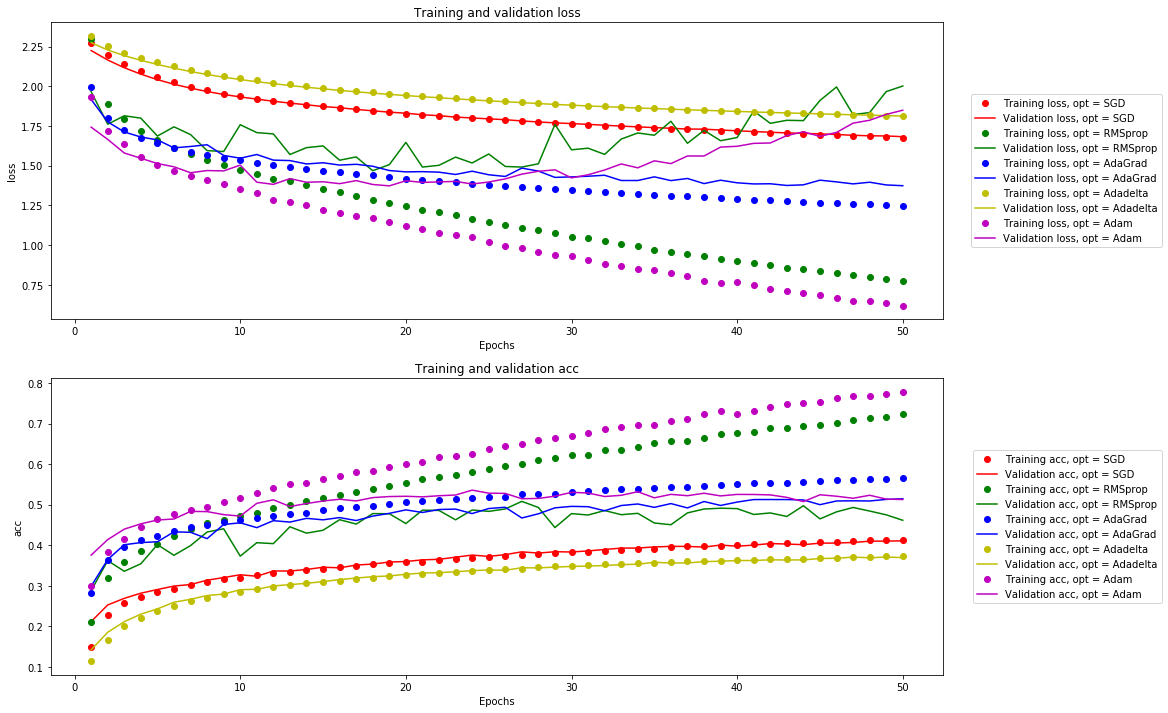

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

rows, cols = 2, 1
figure, ax = plt.subplots(rows, cols, figsize=(16,12))

for i, score in enumerate(['loss', 'acc']):
    for color, tg in zip(color_bar, results.keys()):
        plt.subplot(rows, cols, i+1)
        plt.plot(range(1, epochs+1), results[tg]['train-'+score], 'o', label=f"Training {score}, {tg}", color=color)
        plt.plot(range(1, epochs+1), results[tg]['valid-'+score], '-', label=f"Validation {score}, {tg}", color=color)
        plt.title('Training and validation '+score)
        plt.xlabel('Epochs')
        plt.ylabel(score)
        plt.legend(loc='right', bbox_to_anchor=(1.25, 0.5))